### Import Library

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### Import data

앞서 2장때 이미지를 불러오는 방법을 배웠습니다.

이를 이용하여 tensorflow를 이용하여 딥러닝에 학습을 시킬 수 있는 형태로 바꾸어주도록 하겠습니다.

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True,
                                   )
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 1s 0us/step


In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(224, 224),
  batch_size=16)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(224, 224),
  batch_size=16)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


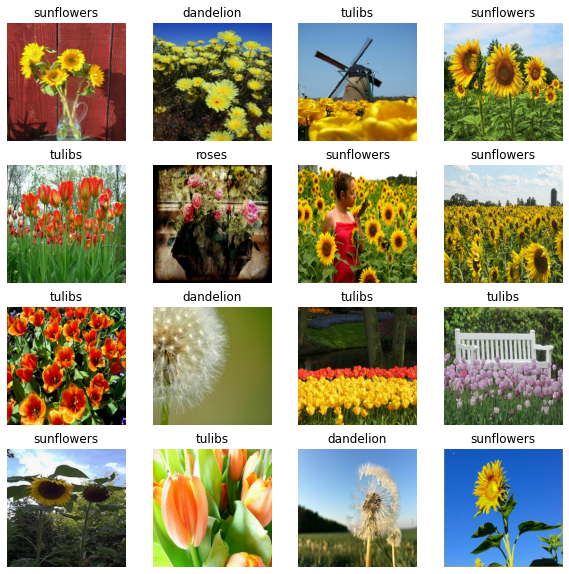

In [ ]:
class_names = ['daisy','dandelion','roses','sunflowers','tulibs']
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### 모델 정의

이제 Convolution layer를 통해 모델을 직접 생성해보도록 하겠습니다.

현재 baseline code는 최소한의 동작할 수 있는 정도로만 구현을 하였습니다. 그렇기에 train과 valid/test 사이에 성능 차이가 매우 심할 것입니다.

여기에 여러분들이 어떻게 하면 성능을 향상시킬 수 있을 지, 공부해보고 모델을 비교해보면 되겠습니다.

고려할 점들

- 모델의 정도: 깊게 쌓을 것인가(Layer를 늘릴지), 혹은 넓게 쌓을 것인가(Filter를 늘릴지), kernal_size를 어떻게 조절할 것인지?
- Dropout: Overfitting을 어떻게 방지할 것인가?
- Batch Normalization: 배치 단위로 정규화를 넣어줄 것인지
- Activation function: 다른걸 써볼 수 있을지 (그러나 CNN의 국룰은 ReLU임)
- 그 외

In [ ]:
### 모델 정의
class CNN(tf.keras.Model):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu', padding = "same", input_shape = (224,224,3))
        self.pool1 = tf.keras.layers.MaxPooling2D((2,2))
        self.layer2 = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu', padding = "same")
        self.pool2 = tf.keras.layers.MaxPooling2D((2,2))
        self.flat = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(128, activation = "relu")
        self.fc2 = tf.keras.layers.Dense(5, activation = "softmax")

    def call(self, x):
        out = self.layer1(x)
        out = self.pool1(out)
        out = self.layer2(out)
        out = self.pool2(out)
        out = self.flat(out)
        out = self.fc1(out)
        return self.fc2(out)

Task에 맞는 적절한 loss와, 데이터에 맞는 optimizer를 선택하는 것도 학습에 영향을 줍니다.

- Loss: 어떤 loss를 사용할 것인가?
- Optim: SGD 외에 RMSprop, Adam 등으로 바꾸면 학습에 어떤 영향을 미치는가?
- Learning rate: 어느정도의 속도로 학습할 것인가?

In [ ]:
### 모델 및 파라미터 할당
model = CNN()
learning_rate = 1e-4
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(lr=learning_rate)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
### 모델 동작 확인
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
model.build(input_shape=(1, 224, 224, 3))
model.summary()

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  896       
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           multiple                  18496     
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  25690240

### 모델 훈련

이제 모델과 학습 요소들을 모두 정의했다면, 데이터를 통해 모델을 훈련해보도록 하겠습니다.

In [ ]:
### 모델 훈련
with tf.device("/device:GPU:0"):
    hist = model.fit(train_ds, epochs=10, batch_size=32,
                    validation_data=val_ds)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


184/184 [==============================] - 20s 45ms/step - loss: 14.9007 - accuracy: 0.4172 - val_loss: 1.2884 - val_accuracy: 0.4837
Epoch 2/10
184/184 [==============================] - 8s 42ms/step - loss: 1.0721 - accuracy: 0.5763 - val_loss: 1.1947 - val_accuracy: 0.5204
Epoch 3/10
184/184 [==============================] - 11s 58ms/step - loss: 0.9059 - accuracy: 0.6621 - val_loss: 1.1577 - val_accuracy: 0.5354
Epoch 4/10
184/184 [==============================] - 8s 45ms/step - loss: 0.7638 - accuracy: 0.7207 - val_loss: 1.1934 - val_accuracy: 0.5245
Epoch 5/10
184/184 [==============================] - 8s 41ms/step - loss: 0.6491 - accuracy: 0.7793 - val_loss: 1.1191 - val_accuracy: 0.5504
Epoch 6/10
184/184 [==============================] - 8s 40ms/step - loss: 0.5407 - accuracy: 0.8290 - val_loss: 1.1324 - val_accuracy: 0.5545
Epoch 7/10
184/184 [==============================] - 8s 40ms/step - loss: 0.4506 - accuracy: 0.8719 - val_loss: 1.1597 - val_accuracy: 0.5708
Epoch 8

### 모델 평가

모델이 학습을 모두 완료했다면, 새로운 데이터를 통해 얼마나 잘 맞추었는가를 평가해보겠습니다.

In [ ]:
### 평가
model.evaluate(val_ds)

46/46 [==============================] - 1s 26ms/step - loss: 1.1798 - accuracy: 0.5654


[1.1797977685928345, 0.5653951168060303]

In [ ]:
y_prob = model.predict(val_ds)

In [ ]:
### 예측
y_prob = model.predict(val_ds)
y_pred = np.argmax(y_prob, axis=1)
y_test = np.concatenate([y for x, y in val_ds], axis=0)

In [ ]:
### 예측 리포트
from sklearn.metrics import classification_report, confusion_matrix
print('\n Classification report \n\n',
  classification_report(
      y_test,
      y_pred,
       target_names=class_names
      )
  )


 Classification report 

               precision    recall  f1-score   support

       daisy       0.14      0.10      0.12       129
   dandelion       0.21      0.23      0.22       176
       roses       0.16      0.21      0.18       120
  sunflowers       0.13      0.12      0.12       152
      tulibs       0.20      0.19      0.20       157

    accuracy                           0.17       734
   macro avg       0.17      0.17      0.17       734
weighted avg       0.17      0.17      0.17       734



(<matplotlib.legend.Legend at 0x7f66dc89e210>, None)

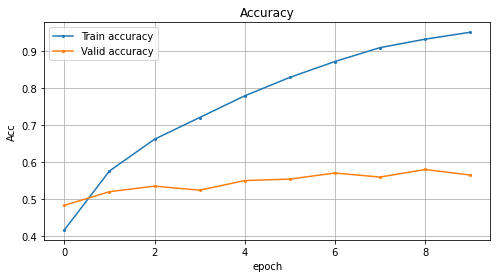

In [ ]:
plt.figure(figsize = (8,4))
plt.plot(hist.history['accuracy'],marker = 'o', ms = 2, label = "Train accuracy")
plt.plot(hist.history['val_accuracy'],marker = 'o', ms = 2, label = "Valid accuracy")
plt.title(f'Accuracy');
plt.ylabel('Acc');
plt.xlabel('epoch')
plt.legend(), plt.grid()

(<matplotlib.legend.Legend at 0x7f66dc8250d0>, None)

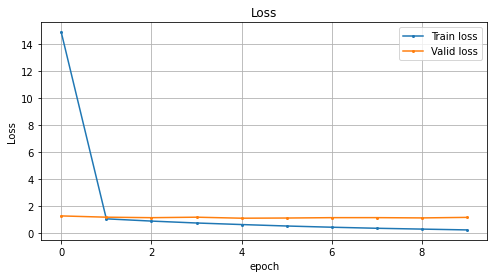

In [ ]:
plt.figure(figsize = (8,4))
plt.plot(hist.history['loss'],marker = 'o', ms = 2, label = "Train loss")
plt.plot(hist.history['val_loss'],marker = 'o', ms = 2, label = "Valid loss")
plt.title(f'Loss');
plt.ylabel('Loss');
plt.xlabel('epoch')
plt.legend(), plt.grid()